Looking at the UVES data of TRAPPIST-1, in particular looking for H alpha variablity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box1DKernel


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/5tb_storage1/muscles/t1_uves/'
dpath = '{}data/'.format(path)
spectra = glob.glob('{}*.fits'.format(dpath))
spectra

['/media/david/5tb_storage1/muscles/t1_uves/data/ADP.2020-06-09T07 23 59.909.fits',
 '/media/david/5tb_storage1/muscles/t1_uves/data/ADP.2020-06-09T07 26 05.269.fits',
 '/media/david/5tb_storage1/muscles/t1_uves/data/ADP.2020-06-09T07 29 30.354.fits',
 '/media/david/5tb_storage1/muscles/t1_uves/data/ADP.2020-06-09T07 34 59.718.fits',
 '/media/david/5tb_storage1/muscles/t1_uves/data/ADP.2020-06-28T19 56 29.013.fits',
 '/media/david/5tb_storage1/muscles/t1_uves/data/ADP.2020-06-28T19 56 29.046.fits',
 '/media/david/5tb_storage1/muscles/t1_uves/data/ADP.2020-08-14T12 00 19.998.fits',
 '/media/david/5tb_storage1/muscles/t1_uves/data/ADP.2020-08-14T12 34 48.469.fits']

In [3]:
halpha = 6562.81

No calibrated flux
6506.81029081387 10252.506963470238


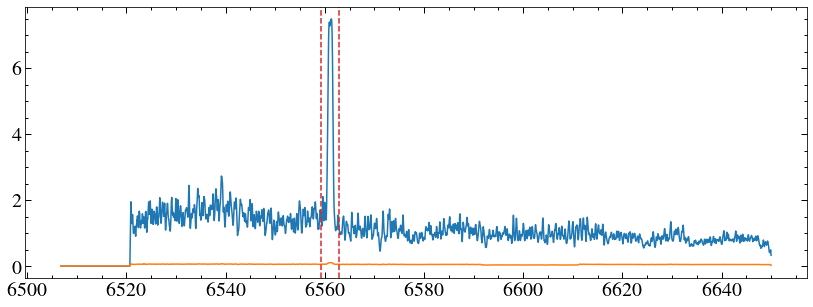

No calibrated flux
6506.78871555506 10252.455414372442


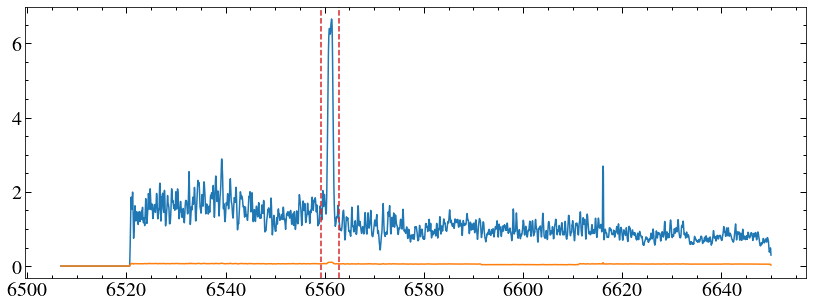

No calibrated flux
6506.80213256158 10252.520654402275


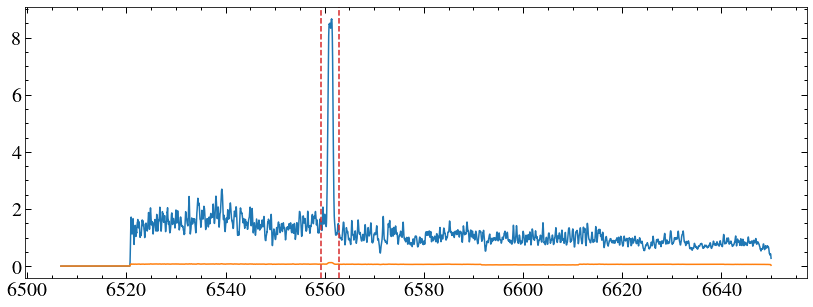

No calibrated flux
6506.77588113007 10252.499065209282


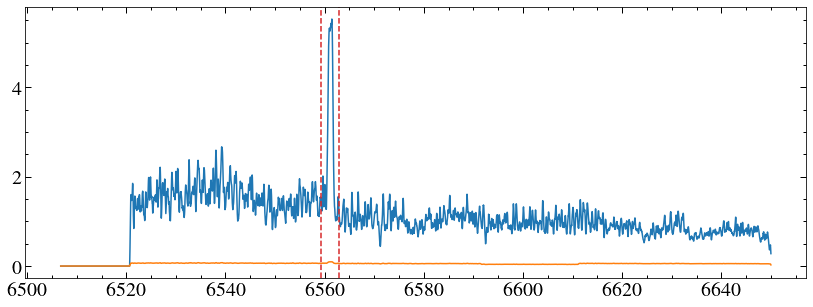

3732.15155770107 4999.810929362892
No calibrated flux
6437.91779532495 10252.304736710252


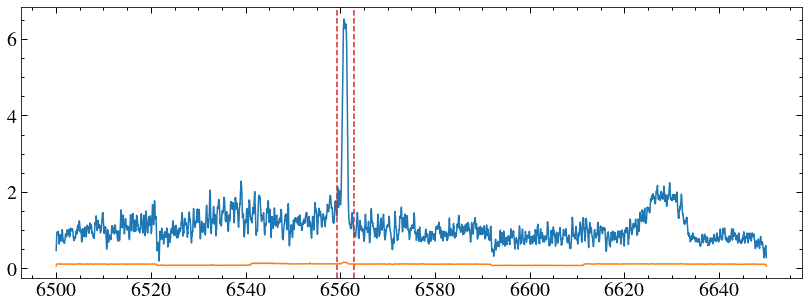

6650.35086245388 10426.260330751113
6650.37760475858 10425.654656820825


In [18]:
smooth = 10
hspecs= []
for spec in spectra:
   
    data = fits.getdata(spec, 1)[0]
    try:
        wi, fi, ei = data['WAVE'], data['FLUX']*1e-16, data['ERR']*1e-16
        print(wi[0], wi[-1])
        mask = (wi > 6500) & (wi < 6650)
        w, f, e= wi[mask], fi[mask], ei[mask]
        if len(w) > 0:
            f = convolve(f,Box1DKernel(smooth))
            e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
            plt.plot(w, f)
            plt.plot(w, e)
            plt.show()
    except:
        print('No calibrated flux')
        wi, fi, ei = data['WAVE'], data['FLUX_REDUCED'], data['ERR_REDUCED']
        print(wi[0], wi[-1])
        mask = (wi > 6500) & (wi < 6650)
        w, f, e= wi[mask], fi[mask], ei[mask]
        if len(w) > 0:
            f = convolve(f,Box1DKernel(smooth))
            e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
            plt.plot(w, f/np.median(f))
            plt.plot(w, e/np.median(f))
            plt.axvline(halpha, c='C3', ls='--')
            plt.axvline(halpha-3.5, c='C3', ls='--') #guessing positions to mask
            plt.show()
            hspecs.append(spec)
    

In [6]:
hspecs

['/media/david/5tb_storage1/muscles/t1_uves/data/ADP.2020-06-09T07 23 59.909.fits',
 '/media/david/5tb_storage1/muscles/t1_uves/data/ADP.2020-06-09T07 26 05.269.fits',
 '/media/david/5tb_storage1/muscles/t1_uves/data/ADP.2020-06-09T07 29 30.354.fits',
 '/media/david/5tb_storage1/muscles/t1_uves/data/ADP.2020-06-09T07 34 59.718.fits',
 '/media/david/5tb_storage1/muscles/t1_uves/data/ADP.2020-06-28T19 56 29.046.fits']

In [20]:
fitter = fitting.LinearLSQFitter()

def wavelength_edges(w, gap=10):
    """
    Calulates w0 and w1, accounting for gaps induced by masking etc
    """
    diff = np.diff(w)
    diff = np.insert(diff, (0, len(diff)), (diff[0], diff[-1])) #adds an extravalue to make len(diff) = len(w)+1
    w0 = []
    w1 = []
    for i, wi in enumerate(w):
        w0i, w1i = diff[i]/2, diff[i+1]/2
        if (max(w0i, w1i)/min(w0i, w1i)) > gap:
            w0i, w1i = min(w0i, w1i), min(w0i, w1i)
        w0.append(wi - w0i)
        w1.append(wi + w1i)
    
    return np.array(w0), np.array(w1)

def make_plot_spec(w, f, e, mask1, mask2, smooth=10): #cuts spectrum down to the bit to plot
    w1, f1 = w[mask1], f[mask1]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    nf = f/n_fit(w)
    ne = e/n_fit(w)
    if smooth == 0:
        smooth = 1
    nf = convolve(nf,Box1DKernel(smooth))
    ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5
    w1, f1, e1 = w[mask2], nf[mask2], ne[mask2]
    return w1,f1, e1

 [astropy.modeling.fitting]


5.222527991489519 0.2536310263290801


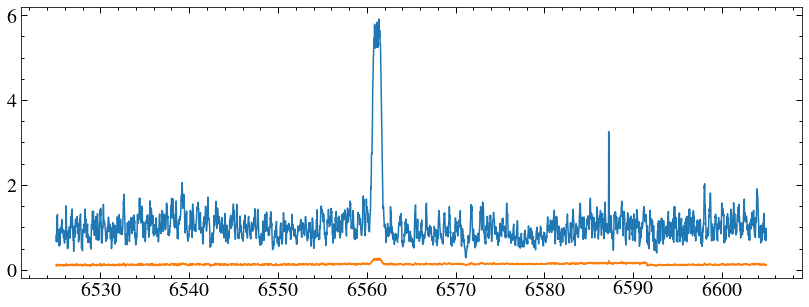

 [astropy.modeling.fitting]


4.581609896538128 0.37950469213445936


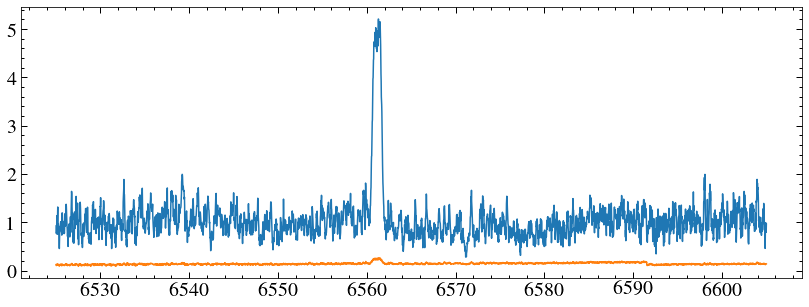

 [astropy.modeling.fitting]


6.208487685356991 0.1595390224537312


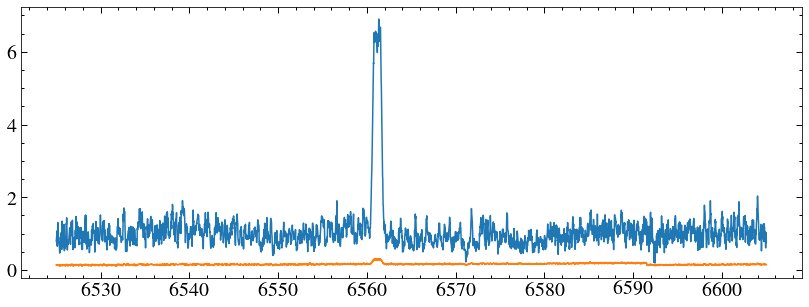

 [astropy.modeling.fitting]


3.3727076871815136 0.5915696611192772


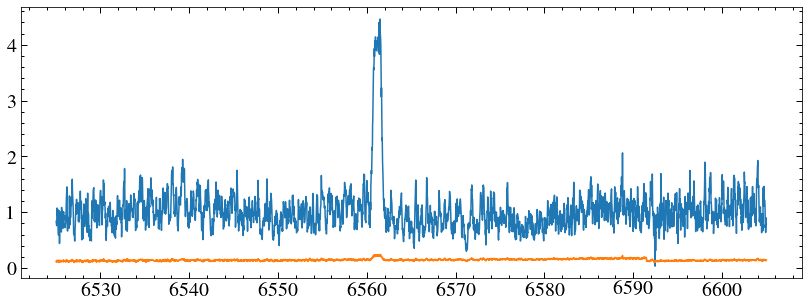

 [astropy.modeling.fitting]


6.141953092950811 0.30208241286600857


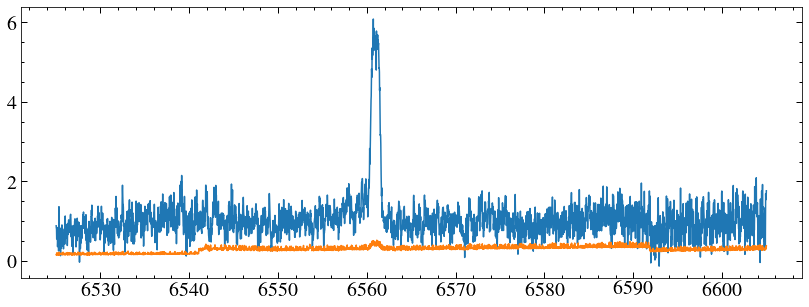

In [41]:
ews= []
ew_es = []

dates = []
for spec in hspecs:
    data = fits.getdata(spec, 1)[0]
    hdr= fits.getheader(spec)
    date = hdr['MJD-OBS'] + (hdr['TEXPTIME']/(86400*2))
    dates.append(date)
    wi, fi, ei = data['WAVE'], data['FLUX_REDUCED'], data['ERR_REDUCED']
    mask1 = (wi > 6530) & (wi < halpha-3.5) | (wi > halpha) & (wi < 6610)
    mask2 = (wi > 6525) & (wi < 6605)
    wn, fn, en = make_plot_spec(wi, fi, ei, mask1, mask2, smooth=1)
    plt.plot(wn, fn)
    plt.plot(wn, en)
    w1, w0 = wavelength_edges(wn)
    mask = (wn > halpha-5.5) & (wn < halpha+2)
    eqw = np.sum((1-fn[mask])*(w1[mask]-w0[mask]))
    eqw_e=((1.+(1./np.mean(fn[mask])))**(0.5)) * (((wn[mask][-1]-wn[mask][0])-eqw)/(np.mean(fn[mask])/np.mean(en[mask])))
    ews.append(eqw)
    ew_es.append(abs(eqw_e))
    print(eqw, eqw_e)
    plt.show()
    


In [36]:
# fits.getheader(hspecs[0], 0)

<ErrorbarContainer object of 3 artists>

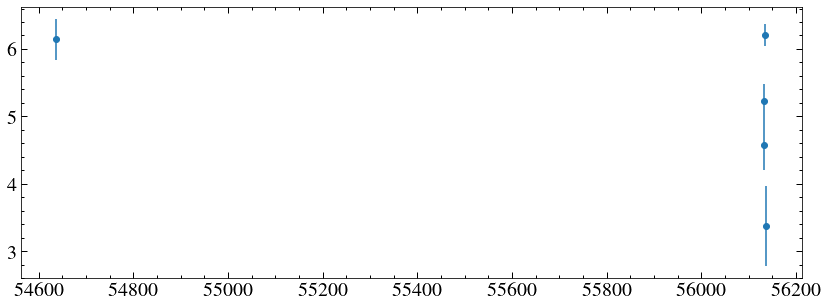

In [42]:
plt.errorbar(dates, ews, yerr=ew_es, ls='none', marker='o')

In [38]:
print(dates)

[56131.21686622945, 56132.21425233398, 56134.221331409775, 56137.22842334724, 54637.28010707012]


In [43]:
#Melbourne+20 
m_ew = -3.25676
m_ewe = 1.086027

<ErrorbarContainer object of 3 artists>

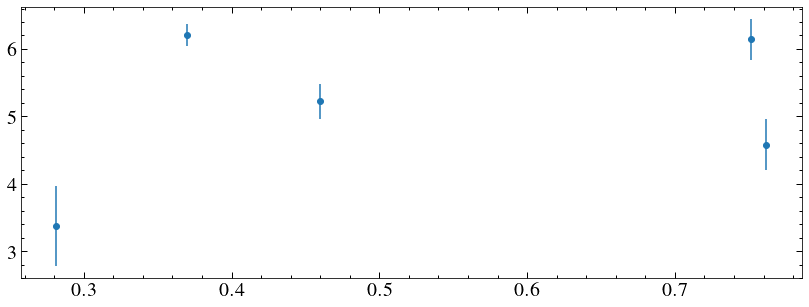

In [45]:
tfold = (np.array(dates)/3.3) % 1 #kepler "period"
plt.errorbar(tfold, ews, yerr=ew_es, ls='none', marker='o')